Here we simulate an NMR experiment to illustrate simple quantum gates with two qubits. We start with an initial state, described by the density matrix in the logical (rotating) frame, apply some time evolution operators and than measure the magnetization to obtain a sample to which we can apply a Fourier transformation.
The molecule that we simulate is TCE, and we use the two carbons, with a Larmor frequency of 125 MHz and a chemical shift of 900 Hz. The coupling is 100 Hz (values taken from http://arXiv.org/abs/quant-ph/0207172v1). We set $\hbar = 1$.

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
# Conversion factor between frequencies in Hz and frequencies in rad/s
conv = 2*np.pi
# Larmor frequencies
w0 = 125000000*conv
w1 = (125000000+900)*conv
w12 = (100/(2*np.pi))*conv

First we need a function that initializes the density matrix. We simplify things a bit and start with a pseudo-pure state
$$
\rho = \frac{1}{4} (1-\epsilon) + \epsilon |0 \rangle \langle 0 |
$$

In [2]:
####################################
# Initialize the density matrix    #
####################################
def initPseudoPureState(e=0.5):
    r = np.diag(np.ones(4)*(1-e)*0.25)
    r[0][0] += e
    return r

Next we need some standard time evolution operators. We start with the free evolution. The following function returns the Hamiltonian under free evolution in the logical frame. The chemical term is therefore zero, and the only term is the coupling term 
$$
\frac{2 \pi}{\hbar} J_{12} I^1_z I^2_z = \pi \frac{\hbar}{2} J_{12} \sigma_z^1 \sigma_z^2
$$

In [3]:
####################################
# Free evolution hamiltonian       #
# w12 - J-coupling                 #
####################################
def freeEvolutionHamiltonian():
    # The tensor product of the two sigma z Pauli matrices is of course
    # course diagonal with eigenvalues (+1, -1, -1, +1). We simply 
    # multiply this by the constant
    return w12*0.5* np.pi * np.diag([1, -1, -1, +1])

The following function will, for a given Hamiltonian, calculate the time evolution for a time t, given by
$$
U(t) = \exp (- \frac{i}{\hbar} Ht)
$$

In [4]:
###################################
# Time evolution operator         #
###################################
def timeEvolutionOperator(H, t):
    return scipy.linalg.expm(-1j*H*t)


Next, we need a function that simulates the evolution of the density matrix (again in the logical frame) under the time evolution operator U. This is simply given by conjugation with the time evolution operator

In [5]:
###################################
# Evolve density matrix           #
###################################
def evolveDensityMatrix(r, U):
    return np.matmul(np.matmul(U, r), np.matrix(U).H)

def applyHamiltonian(r, H, t):
    return  evolveDensityMatrix(r, timeEvolutionOperator(H,t))

We will now implement a few standard one- and two-qubit operators. We start with rotations. A rotation on the Bloch sphere by an angle $\Theta$ around the x-axis is described by
$$
R_x(\Theta) = e^{-\frac{i}{\hbar}\Theta I_z} = e^{-\frac{1}{2} i \Theta \sigma_z}
$$
and similar for the y-axis. So we need the Pauli matrices
\begin{align}
\sigma_x &= \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \\
\sigma_y &= \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} \\
\sigma_z &= \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} 
\end{align}

In [6]:
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

#################################################
# Rotation around the x-axis                    #
#################################################
def rotX(theta, i):
    if (i == 0):
        return np.kron(scipy.linalg.expm(-0.5*1j*theta*sx), np.diag(np.ones(2)))
    return np.kron(np.diag(np.ones(2)), scipy.linalg.expm(-0.5*1j*theta*sx))


#################################################
# Rotation around the y-axis                    #
#################################################
def rotY(theta, i):
    if (i == 0):
        return np.kron(scipy.linalg.expm(-0.5*1j*theta*sy), np.diag(np.ones(2)))
    return np.kron(np.diag(np.ones(2)), scipy.linalg.expm(-0.5*1j*theta*sy))


#################################################
# Rotation around the z-axis                    #
#################################################
def rotZ(theta, i):
    if (i == 0):
        return np.kron(scipy.linalg.expm(-0.5*1j*theta*sz), np.diag(np.ones(2)))
    return np.kron(np.diag(np.ones(2)), scipy.linalg.expm(-0.5*1j*theta*sz))



Now we turn to measurements. First, we need to be able to extract the magnetization in the logical frame from a density matrix. We can do this by multiplying the density matrix with the components of the angular momentum and taking the trace.

In [7]:
#################################################
# Determine magnetization                       #
#################################################
def getMagnetization(r):
    mx = np.zeros(2)
    my = np.zeros(2)
    Ix1 = 0.5* np.kron(sx, np.diag(np.ones(2)))
    Iy1 = 0.5* np.kron(sy, np.diag(np.ones(2)))
    Ix2 = 0.5* np.kron(np.diag(np.ones(2)), sx)
    Iy2 = 0.5* np.kron(np.diag(np.ones(2)), sy)
    mx[0] = np.real(np.trace(np.matmul(r, Ix1)))
    mx[1] = np.real(np.trace(np.matmul(r, Ix2)))
    my[0] = np.real(np.trace(np.matmul(r, Iy1)))
    my[1] = np.real(np.trace(np.matmul(r, Iy2)))
    return mx, my

Let us now try to understand the signal that a magnetization causes in a coil along the x-axis. We can calculate the signal induced in the coil (after pre-processing in a quadrature detection circuit) expressed in terms of the magnetization $\widetilde{m}$ in the logical frame as
$$
s(t) = \sum_i \omega_i (\widetilde{m}_x(t) + i \widetilde{m}_y(t)) e^{i \Omega^i t} 
$$
where 
$$
\Omega^i = \omega_{ref} - \omega_i
$$

In [8]:
##########################################
# Calculate the signal                   #
##########################################
def signal(wref, mx, my, t):
    s = (mx[0] + 1j*my[0]) * np.exp(1j*(wref-w0)*t)
    s += (mx[1] + 1j*my[1]) * np.exp(1j*(wref-w1)*t)
    return s
    
#########################################
# Take a sample                         #
# dt - sample period                    #
# T - total duration of sampling        #
# wref - reference frequency            #
# r- initial density matrix             #
# tau - decay factor                    #
# J - set this to one to simulate       #
#     coupling                          #
#########################################
def sample(r, dt, T, wref, tau, J = 0):
    # Take samples
    y = []
    t = np.arange(0, T, dt)
    decay = 1
    decay_step = np.exp(-tau*dt)
    # Calculate the time evolution operator once
    # for the time dt
    H = J*freeEvolutionHamiltonian()
    U = timeEvolutionOperator(H, dt)
    for _t in t:
        # Get magnetization
        mx, my = getMagnetization(r)
        mx = decay * mx
        my = decay * my
        s = signal(wref, mx, my, _t)
        y.append(s)
        # Update decay factor
        decay = decay * decay_step
        # and apply time evolution
        r = evolveDensityMatrix(r, U)
    return y

We will use the FFT routine provided by numpy to do the Fourier transform. Let us try to understand how the output of the FFT is related to the spectrum. The vector that we feed into the FFT has components
$$
s_k = s(dt \cdot k)
$$
The complex FFT takes the vector $s_k$ and calculates a vector $S_k$ given by
$$
S_k = \sum_{m=0}^{N-1} s_m \exp\left\{-2\pi i{mk \over N}\right\} \qquad k = 0,\ldots,N-1.
$$
Up to a factor of $2 \pi$, the inverse is given by
$$
s_k = \sum_{m=0}^{N-1} S_m \exp\left\{2\pi i{mk \over N}\right\}
$$
If S has a very sharp peak at one index $k$, then 
$$
s_j = \exp\left\{2\pi i{kj \over N}\right\}
$$
i.e. expressed in terms of the signal $s$, we have a signal which is approximately described by
$$
s(dt \cdot j) = \exp\left\{2\pi i{kj \over N}\right\}
$$
or
$$
s(t) = s(\frac{t}{dt} dt) = \exp\left\{2\pi i{k t \over dt N}\right\}
$$
which corresponds to a frequency
$$
\Omega =  { 2\pi  k \over T}
$$
where $T = N dt$ is the total duration of the measurement. Thus we need to scale the x-axis by the factor 
$$
{ 2\pi  \over T}
$$
when we plot the results of the FFT. Note that negative frequencies will appear in the components close to $N$ and cannot easily be distinguished from positive frequencies due to the periodicity. Therefore we should choose the reference frequency greater than the involved Larmor precession frequencies. 

In [9]:
##########################################
# Calculate and plot the FFT of a signal #
# wref - reference frequency             #
# fmin - minimimum frequency to look at  #
# T - duration of sampling               #
# Inputs are specified in rad s**(-1)    #
##########################################

def showFFT(y, wref, fmin, T):
    f = np.fft.fft(y)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    N = len(f)
    X = (wref - 2*np.pi/T*np.arange(N))
    # We zoom into the low frequency area. We plot the area between fmin and the reference 
    # frequency
    kmin = int(T/(2*np.pi)*(wref-fmin))
    ax.plot(1/conv*X[:kmin], np.real(f)[:kmin])
    ax.set_ylabel("Amplitude",fontsize=20)
    ax.set_xlabel("$\omega - \omega_0$ (Hz)", fontsize=20)
    ax.set_yticks([])
    plt.show()

We are now ready to run our first experiment. We start with an initial pseudo-pure state. This state will be diagonal and commute with the Hamiltonian, i.e. it is a stationary state. Next we apply a rotation around the y-axis by the angle $\pi/2$ to both spins. We then take a sample. We expect to see two peaks, located at the Larmor frequencies $\omega_0$ and $\omega_1 = \omega_0 + \delta$ with the chemical shift $\delta$ of roughly 900 Hz.

Magnetization in x-direction: [ 0.25  0.25]
Magnetization in y-direction: [ 0.  0.]


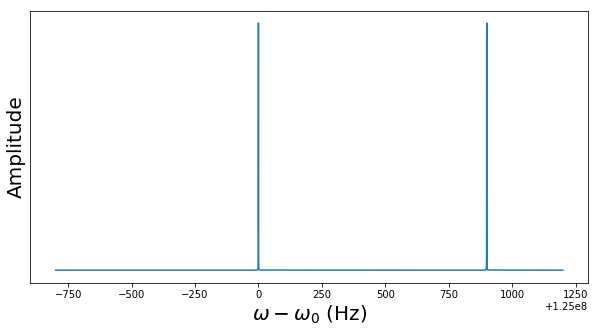

In [10]:
r = initPseudoPureState()
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 0))
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 1))
mx, my = getMagnetization(r)
print("Magnetization in x-direction:", mx)
print("Magnetization in y-direction:" , my)

# Reference frequency. To make sure that our frequencies are positive, we have to choose a reference
# frequency that is greater than w0 and w1
wref = w0 + 1200*conv
# Sampling interval. The resolution is in the order of 1 / dt
dt = 0.0001
# Overall sampling time
T = 4
# Decay factor
tau = 0.8
y = sample(r, dt, T, wref, tau)
showFFT(y, wref, -2000*conv + wref, T)

Now let us investigate the impact of a spin flip. We repeat the experiment above, but this time, we first apply a rotation around the x-axis by an angle $\pi$, i.e. we apply $\sigma_x$ on the first qubit. 

In [11]:
r = initPseudoPureState()
r = evolveDensityMatrix(r, rotX(np.pi, 0))
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 0))
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 1))
mx, my = getMagnetization(r)
print("Magnetization in x-direction:", mx)
print("Magnetization in y-direction:" , my)

Magnetization in x-direction: [-0.25  0.25]
Magnetization in y-direction: [ 0.  0.]


As expected, this has flipped the magnetization in the x-direction for the first qubit. Let us now repeat the sampling and the FFT to see how this affects the spectrum.

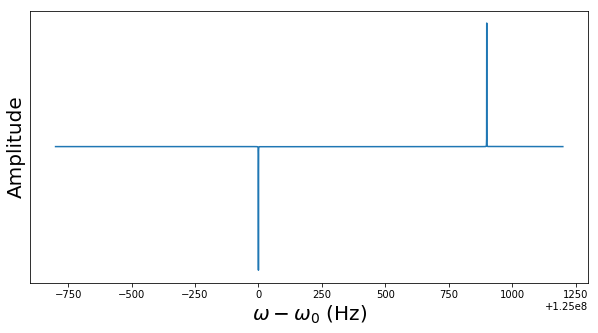

In [12]:
y = sample(r, dt, T, wref, tau)
showFFT(y, wref, -2000*conv + wref, T)

We can clearly see that the amplitude of the first qubit has been reversed, as expected. Next, let us try to simulate the impact of coupling. We repeat our second experiment, but apply coupling during the measurement.

Magnetization in x-direction: [ 0.25  0.25]
Magnetization in y-direction: [ 0.  0.]


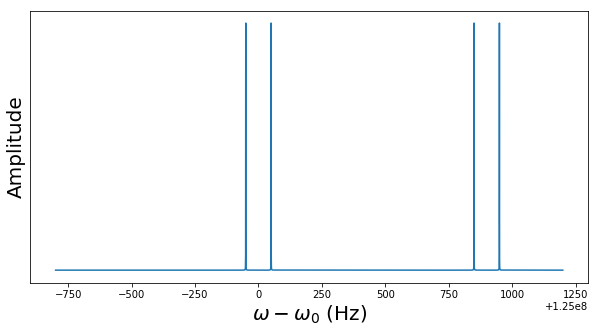

In [29]:
r = initPseudoPureState()
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 0))
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 1))
mx, my = getMagnetization(r)
print("Magnetization in x-direction:", mx)
print("Magnetization in y-direction:" , my)
wref = w0 + 1200*conv
y = sample(r, dt, T, wref, tau, J = 1)
showFFT(y, wref, -2000*conv + wref, T)

We find that the coupling introduces a splitting - each peak is split into two peaks, with a distance given by the coupling frequency.

Next, let us turn to initial states that are thermal states, i.e. given by the Boltzmann distribution. Ignoring the small coupling terms and the chemical shift, i.e. applying the usual approximation for homonuclear systems, the initial density matrix is given by
$$
\rho = \frac{1}{4} + \frac{1}{4} \frac{\beta}{\hbar} I_z = \frac{1}{4} + \frac{1}{8} \beta \sigma_z
$$
where $\beta$ is in the order of $10^{-4}$ at room temperature and $\sigma_z$ is the z-component of the total angular momentum, i.e. the sum $\sigma_z^1 + \sigma_z^2$. 

In [14]:
################################################
# Density matrix for a thermal state           #
################################################
def thermalState(beta):
    r = np.diag(np.ones(4))*0.25
    r = r + 0.125 * beta * (np.kron(sz, np.diag(np.ones(2))) + np.kron(np.diag(np.ones(2)), sz))
    return r

[[ 0.250025  0.        0.        0.      ]
 [ 0.        0.25      0.        0.      ]
 [ 0.        0.        0.25      0.      ]
 [ 0.        0.        0.        0.249975]]
Magnetization in x-direction: [  2.50000000e-05   2.50000000e-05]
Magnetization in y-direction: [ 0.  0.]


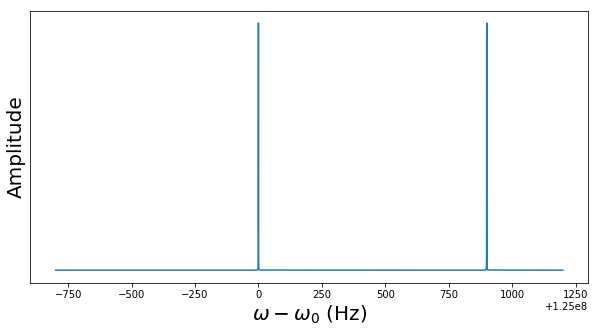

In [15]:
r = thermalState(0.0001)
print(r)
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 0))
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 1))
mx, my = getMagnetization(r)
print("Magnetization in x-direction:", mx)
print("Magnetization in y-direction:" , my)
wref = w0 + 1200*conv
y = sample(r, dt, T, wref, tau, J = 0)
showFFT(y, wref, -2000*conv + wref, T)

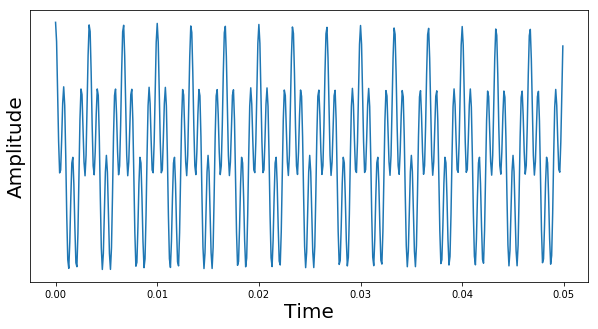

In [16]:
# Plot the signal as well
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
time_axis = np.arange(0, T, dt)
ax.plot(time_axis[:500], np.real(y)[:500])
ax.set_ylabel("Amplitude",fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_yticks([])
plt.show()

We can repeat this experiment, but this time, we flip only the spin of the first nucleus. We therefore expect a pure (damped) oscillation and one peak in the Fourier transformed spectrum.

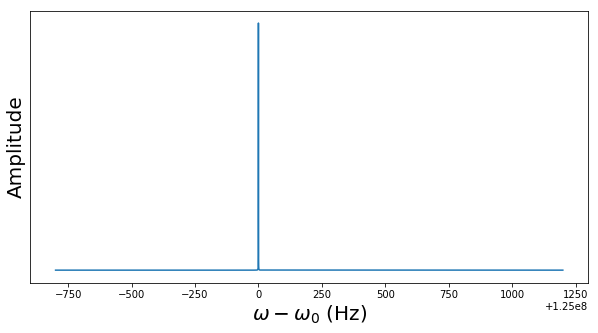

In [17]:
r = thermalState(0.0001)
r = evolveDensityMatrix(r, rotY(np.pi*0.5, 0))
mx, my = getMagnetization(r)
wref = w0 + 1200*conv
y = sample(r, dt, T, wref, tau, J = 0)
showFFT(y, wref, -2000*conv + wref, T)

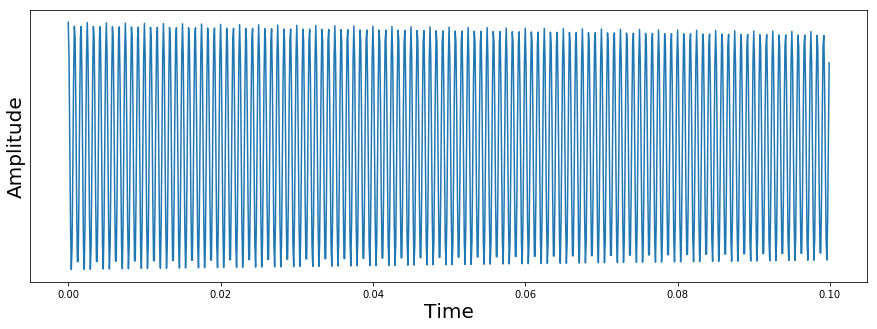

In [25]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
time_axis = np.arange(0, T, dt)
ax.plot(time_axis[:1000], np.real(y)[:1000])
ax.set_ylabel("Amplitude",fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_yticks([])
plt.show()